In [1]:
import numpy as np
import pandas as pd
import re,math
from sklearn import preprocessing
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


#已有的35细胞系
data = pd.read_csv(r'35_CCLE4000.csv')

In [2]:
data.head()

,Name,MT.CO2,MT.CO1,MT.RNR2,FTL,EEF1A1P5,RPS18,TMSB10,FN1,MT.ND2,...,G3BP1,FAS,MIA,TNFRSF1B,PIK3CD,RAVER1,NEUROD6,IGHV2.26,RP11.254B13.1,MYRF
0,A2058,138.664175,99.733470,29.362917,33.507670,28.580983,32.005938,10.723401,4.332792,46.013772,...,0.622143,-0.016467,0.225654,-0.087723,0.010787,0.076835,-0.093931,-0.092728,0.178902,0.060812
1,A2780,132.079201,114.522279,43.443616,7.071069,41.351143,20.272538,3.218207,-0.070932,47.875397,...,0.383265,-0.039013,-0.078075,-0.077774,-0.044276,0.350657,-0.078075,-0.078075,0.128915,-0.067700
2,A375,88.664555,82.985653,17.684115,15.773244,54.772199,30.988268,19.931180,0.679905,34.807456,...,0.712732,-0.026034,1.234437,-0.080171,-0.032848,0.775303,-0.118437,-0.118437,0.332271,-0.083249
3,A427,129.025616,89.746054,13.120489,11.230936,23.942771,11.706606,29.606541,-0.044986,88.208783,...,0.173741,0.025657,-0.061178,-0.061313,-0.031394,0.105856,-0.061409,-0.061201,0.096060,-0.026113
4,CAOV3,122.213951,116.564153,43.291175,26.778444,35.949574,17.530583,22.951898,1.567967,53.569745,...,0.493755,0.062419,-0.074416,-0.059800,-0.042722,0.163952,-0.077403,-0.076815,0.117359,-0.055078


In [3]:
name_index = [] 
for i in data['Name']:
    name_index.append(str(i).strip())

In [4]:
#原始数据
origin = pd.read_csv(r'CCLE_EXP(name).csv')

In [5]:
c_list = []
for i in origin.columns:
    c_list.append(str(i))
#原始数据细胞系名称合集

In [6]:
#name = re.findall()
real_names = []
for i in name_index:
    text = i + '.*? '
    cout = 0
    for j in c_list:
        temp_list = re.findall(text, j, re.S)
        if len(temp_list) != 0:
            if (c_list[cout] != 'NCIH2342_LUNG ') & (c_list[cout] != 'NCIH2347_LUNG '):
                real_names.append(c_list[cout])
                break
        cout +=1
#补全后的35细胞系名称

In [7]:
temp = []
for i in real_names:
    temp.append(origin[i])

In [8]:
df = pd.DataFrame(temp)
df = df.transpose()#转置
#合并35细胞系数据

In [9]:
df.index = origin['Name']
#替换行索引为基因名称

In [10]:
#保存筛选结果1
#df.to_csv('Screened_First.csv')

In [11]:
#复制数据，避免误操作
temp_z_score = df.copy()

In [12]:
#zscore标准化
values = temp_z_score.values            #Dataframe转换为Array
values = values.astype('float32')       #定义数据类型
scaler = preprocessing.StandardScaler() #创建Scaler对象
temp = scaler.fit_transform(values)     #稀疏矩阵  
z_score=pd.DataFrame(temp,columns=temp_z_score.columns,index = origin['Name']) #将Array还原为Dataframe，保持行列名

In [13]:
#分割每行并计算各行方差(每个基因的方差)
temp = []
for i in origin['Name']:
    te = z_score.loc[i].values.var()
    temp.append(te)

In [14]:
#方差Dataframe
temp1 = pd.DataFrame(temp,index = origin['Name'],columns=['variance'])

In [15]:
#按照方差排序
temp2 = temp1.sort_values(by="variance",ascending=False)  # by指定按哪列排序。ascending表示是否升序

In [16]:
#取【0:指定位置】区间内基因构成dataframe，选取基因
temp_index = temp2[0:1001].index 
draft_first = z_score.loc[temp_index[0]]
t = draft_first
for i in temp_index:
    temp_data = z_score.loc[i]
    t = t[~t.index.duplicated(keep='first')]
    temp_data = temp_data[~temp_data.index.duplicated(keep='first')]
    t = pd.concat([t,temp_data],axis=1)
t.dropna(subset=['MT-CO2'],inplace=True)

D:\anaconda\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [17]:
#固定区间的标准化后的  基因表达-细胞系   dataframe
df2 = t.transpose().copy()
df2 = df2.drop_duplicates()
df2

,A2058_SKIN,A2780_OVARY,A375_SKIN,A427_LUNG,CAOV3_OVARY,COLO320_LARGE_INTESTINE,DLD1_LARGE_INTESTINE,EFM192A_BREAST,ES2_OVARY,HCT116_LARGE_INTESTINE,...,RPMI7951_SKIN,SKMEL30_SKIN,SKMES1_LUNG,SKOV3_OVARY,SW620_LARGE_INTESTINE,SW837_LARGE_INTESTINE,T47D_BREAST,UACC62_SKIN,VCAP_PROSTATE,ZR751_BREAST
MT-CO2,138.665405,132.080383,88.665337,129.026764,122.215027,130.080261,116.005989,147.931229,150.274933,88.670570,...,139.438217,136.338669,178.673752,103.776741,138.319641,132.701187,159.497208,139.794449,134.107101,106.909081
FTL,33.507965,7.071133,15.773384,11.231036,26.778683,4.013042,19.852560,3.810183,8.348491,19.012960,...,38.770267,3.596164,34.435070,34.991970,6.396747,20.167116,0.791694,21.789629,3.167242,4.184994
MT-ND2,46.014179,47.875832,34.807766,88.209572,53.570221,55.080532,29.537884,39.533794,28.851393,78.043716,...,38.849804,41.071575,25.188255,52.729557,37.203079,53.635746,54.151505,71.736412,47.124008,30.010899
MT-RNR2,29.363176,43.444008,17.684273,13.120606,43.291561,53.964428,14.408345,57.979183,57.678417,79.852448,...,23.452080,33.913666,57.014282,33.238365,59.669575,55.456463,15.444898,21.513290,28.767656,55.377277
EEF1A1P5,28.581236,41.351513,54.772686,23.942986,35.949894,30.014765,19.798353,9.664021,37.236958,44.284988,...,35.605076,30.494646,33.773712,52.704514,47.066708,24.994398,16.572939,18.826252,51.085117,35.221874
RPS18,32.006222,20.272720,30.988544,11.706711,17.530739,21.307968,66.755783,8.641458,28.410555,22.763285,...,22.953163,27.119026,5.948741,15.998391,24.615366,9.835712,15.344304,22.145872,40.093109,27.629436
RPL19,11.882211,8.555707,16.238470,8.034883,3.932894,8.094656,15.538571,91.658264,9.034012,9.435901,...,7.520094,10.318732,4.069162,8.350064,10.532517,6.211339,7.141611,11.881271,13.669010,11.346613
MT-ND1,25.335886,63.186069,13.186865,70.165039,48.372021,56.224739,26.663164,30.755562,14.621216,33.497097,...,17.251152,28.346386,16.760557,34.171021,29.394222,36.645073,31.251616,12.903291,54.574753,21.058720
TMSB10,10.723496,3.218236,19.931358,29.606806,22.952103,2.875170,60.556061,4.808680,27.363129,15.982360,...,48.637642,21.736193,17.283381,53.859051,22.565592,13.159816,3.825876,15.239555,3.291676,20.658228
MT-CO1,99.734352,114.523308,82.986389,89.746857,116.565186,122.392296,67.926041,101.978073,95.717209,89.545090,...,88.446335,118.459991,105.613777,86.452591,97.053726,126.221748,97.670090,97.741669,102.983124,99.839546


In [18]:
#保存筛选结果2
#各基因按照方差排序从大到小排序的标准化后的数据
df2.to_csv('Screened_Second.csv')

In [19]:
#计算皮尔森相关性系数
pearson=df2.corr('pearson')
#spearman.to_csv('spearman.csv')

In [20]:
#保存筛选结果3
pearson.to_csv('pearson.csv')

In [54]:
pearson

,A2058_SKIN,A2780_OVARY,A375_SKIN,A427_LUNG,CAOV3_OVARY,COLO320_LARGE_INTESTINE,DLD1_LARGE_INTESTINE,EFM192A_BREAST,ES2_OVARY,HCT116_LARGE_INTESTINE,...,RPMI7951_SKIN,SKMEL30_SKIN,SKMES1_LUNG,SKOV3_OVARY,SW620_LARGE_INTESTINE,SW837_LARGE_INTESTINE,T47D_BREAST,UACC62_SKIN,VCAP_PROSTATE,ZR751_BREAST
A2058_SKIN,1.000000,0.930303,0.884732,0.868645,0.927124,0.909637,0.810428,0.831336,0.906198,0.872005,...,0.902263,0.936307,0.896322,0.836680,0.919746,0.898601,0.879696,0.940189,0.904770,0.844386
A2780_OVARY,0.930303,1.000000,0.822851,0.908113,0.928270,0.963817,0.757941,0.863127,0.859993,0.877335,...,0.853978,0.915444,0.883852,0.816927,0.927747,0.924535,0.904643,0.873293,0.947305,0.837329
A375_SKIN,0.884732,0.822851,1.000000,0.752383,0.833616,0.817871,0.788270,0.663802,0.782167,0.821025,...,0.820907,0.856694,0.735086,0.789252,0.859466,0.777858,0.717263,0.870437,0.835494,0.853464
A427_LUNG,0.868645,0.908113,0.752383,1.000000,0.888951,0.886601,0.741748,0.812862,0.774588,0.818296,...,0.821334,0.845356,0.811333,0.801864,0.835729,0.862551,0.911358,0.859771,0.867236,0.751837
CAOV3_OVARY,0.927124,0.928270,0.833616,0.888951,1.000000,0.910762,0.795614,0.825683,0.843362,0.885501,...,0.878418,0.921032,0.897195,0.880075,0.914830,0.926968,0.859145,0.893039,0.883418,0.842237
COLO320_LARGE_INTESTINE,0.909637,0.963817,0.817871,0.886601,0.910762,1.000000,0.759500,0.851943,0.863438,0.874798,...,0.825347,0.906216,0.876802,0.787215,0.932565,0.934886,0.880855,0.872788,0.935131,0.879136
DLD1_LARGE_INTESTINE,0.810428,0.757941,0.788270,0.741748,0.795614,0.759500,1.000000,0.685443,0.755758,0.757259,...,0.781792,0.787639,0.734246,0.757528,0.835100,0.788822,0.742190,0.767571,0.778153,0.785078
EFM192A_BREAST,0.831336,0.863127,0.663802,0.812862,0.825683,0.851943,0.685443,1.000000,0.792164,0.760372,...,0.767560,0.815639,0.851061,0.712511,0.840951,0.861734,0.878068,0.796013,0.830264,0.751552
ES2_OVARY,0.906198,0.859993,0.782167,0.774588,0.843362,0.863438,0.755758,0.792164,1.000000,0.799282,...,0.842409,0.875591,0.881378,0.761859,0.885294,0.848319,0.810278,0.842985,0.843781,0.804464
HCT116_LARGE_INTESTINE,0.872005,0.877335,0.821025,0.818296,0.885501,0.874798,0.757259,0.760372,0.799282,1.000000,...,0.764536,0.838065,0.782873,0.820568,0.888155,0.881837,0.773666,0.828605,0.831521,0.812914


In [60]:
# 筛数据
tptp = pearson.copy()
dpdp = pearson.copy()
gl = 0.87
# 筛高相似
while True:
    drop_status = 0
    count = 0
    drop_h = 0
    drop_l = 0
    for i in tptp.values:
        cot = 0
        for j in i:
            if j < gl:
                drop_h = count
                drop_l = cot
                drop_status = 1
                break
            cot += 1
        if drop_status == 1:
            break
        count += 1
    
    #取出对应行
    count = 0 
    for i in tptp.values:
        if count == drop_h:
            drop_h_list = i
            break
        count += 1
    
    #取出对应列
    drop_l_list = []
    for i in tptp.values:
        cot = 0
        for j in i:
            if cot == drop_l:
                drop_l_list.append(j)
            cot += 1
    
    h=np.array(drop_h_list).copy()
    l=np.array(drop_l_list).copy()
    h[h < gl]=10000
    l[l < gl]=10000
    if  np.sum(h) >= np.sum(l):
        tptp.drop(index=[tptp.columns[drop_h]],columns=[tptp.columns[drop_h]],inplace=True)
    elif np.sum(h) < np.sum(l):
        tptp.drop(index=[tptp.columns[drop_l]],columns=[tptp.columns[drop_l]],inplace=True)

    p = np.array(tptp.values).copy()
    p[p < gl]=35*35
    if  np.sum(p) < 35*35:
        break

In [61]:
# 筛低相似 
while True:
    dpdp[dpdp == 1]=-1
    drop_status = 0
    count = 0
    drop_h = 0
    drop_l = 0
    for i in dpdp.values:
        cot = 0
        for j in i:
            if j > gl:
                drop_h = count
                drop_l = cot
                drop_status = 1
                break
            cot += 1
        if drop_status == 1:
            break
        count += 1
    
    #取出对应行
    count = 0
    drop_h_list = []
    for i in dpdp.values:
        if count == drop_h:
            drop_h_list = i
            break
        count += 1
    
    #取出对应列
    drop_l_list = []
    for i in dpdp.values:
        cot = 0
        for j in i:
            if cot == drop_l:
                drop_l_list.append(j)
            cot += 1
    
    h=np.array(drop_h_list).copy()
    l=np.array(drop_l_list).copy()
    h[h > gl]=10000
    l[l > gl]=10000
    if  np.sum(h) >= np.sum(l):
        dpdp.drop(index=[dpdp.columns[drop_h]],columns=[dpdp.columns[drop_h]],inplace=True)
    elif np.sum(h) < np.sum(l):
        dpdp.drop(index=[dpdp.columns[drop_l]],columns=[dpdp.columns[drop_l]],inplace=True)
    p = np.array(dpdp.values).copy()
    p[p > gl]=35*35
    if  np.sum(p) < 35*35:
        break
dpdp[dpdp == -1]=1

In [65]:
tptp.to_csv(r'tptp.csv')
dpdp.to_csv(r'dpdp.csv')
high_similar_regiments = pd.read_csv(r'tptp.csv')
low_similar_regiments = pd.read_csv(r'dpdp.csv')

In [66]:
#读取药物对数据  高相似 低相似团
drugs_data = pd.read_csv(r'Label_synergy4000.csv')

In [67]:
drugs_data

,Unnamed: 0,A2058_SKIN,A2780_OVARY,A375_SKIN,A427_LUNG,CAOV3_OVARY,COLO320_LARGE_INTESTINE,EFM192A_BREAST,ES2_OVARY,HCT116_LARGE_INTESTINE,...,SKMES1_LUNG,SKOV3_OVARY,SW620_LARGE_INTESTINE,SW837_LARGE_INTESTINE,T47D_BREAST,UACC62_SKIN,VCAP_PROSTATE,ZR751_BREAST,DLD1_LARGE_INTESTINE,PA1_OVARY
0,0,-9.510,2.60000,15.200,6.22000,-16.4000,5.360,-7.080,8.050,12.400,...,-6.2300,13.500,5.100,5.150,6.630,3.880,-1.480,-8.660,13.000,4.8300
1,1,-13.200,-4.03000,11.100,10.50000,-15.6000,16.300,-1.720,8.890,0.686,...,2.8200,1.510,13.800,-5.770,-14.400,-10.700,-16.800,-11.800,15.300,-13.1000
2,2,26.400,14.50000,29.500,17.50000,17.7000,10.300,0.830,5.770,19.300,...,-12.2000,-7.400,10.500,-4.970,13.100,18.800,12.000,5.950,6.770,18.9000
3,3,4.330,-8.16000,-5.420,-7.75000,-14.3000,4.810,0.312,3.410,2.920,...,-3.1400,-13.900,-4.570,-19.600,-2.720,3.680,14.400,-13.600,-3.640,-5.7300
4,4,45.500,22.50000,22.800,18.00000,20.1000,22.700,6.300,24.900,35.400,...,24.4000,31.200,18.400,12.900,14.300,34.700,21.200,14.400,26.400,55.4000
5,5,-5.010,-3.86000,25.500,4.91000,-15.3000,21.200,-30.800,4.260,-6.130,...,27.9000,14.900,8.650,0.875,97.800,12.900,4.880,24.200,17.800,-7.4800
6,6,9.970,1.69000,13.200,7.66000,19.2000,7.130,-9.490,14.700,4.010,...,8.3800,-0.318,6.350,-0.448,1.460,12.400,-20.900,8.510,16.100,6.4000
7,7,76.200,21.60000,38.700,-12.10000,22.4000,13.500,-12.000,-53.000,17.400,...,-1.7400,6.090,12.600,-11.500,-14.800,7.910,18.600,7.200,7.200,30.5000
8,8,-16.000,-19.20000,-123.000,-4.42000,-27.2000,17.400,-13.600,11.500,-25.100,...,-7.7700,-15.200,-1.810,-12.800,-13.100,13.300,-36.700,7.440,8.100,-24.1000
9,9,-4.970,11.10000,8.950,6.89000,-1.1600,-48.400,16.800,3.900,8.670,...,-9.6300,20.100,1.530,-9.930,-8.420,4.380,-1.660,-8.310,-8.440,6.2800


In [68]:
#取各团的细胞系名
high_cells = high_similar_regiments.columns[1:]

In [69]:
low_cells = low_similar_regiments.columns[1:]

In [70]:
drugs_temp = []
j = 0
for i in drugs_data.columns[1:]:
    drugs_temp.append(drugs_data[i].rename(real_names[j]))
    j += 1

In [71]:
#预处理drugs
t = drugs_temp[0].rename(real_names[0])
for i in drugs_temp[1:]:
    t = pd.concat([t,i],axis=1)
drugs = t.copy()
drugs

,A2058_SKIN,A2780_OVARY,A375_SKIN,A427_LUNG,CAOV3_OVARY,COLO320_LARGE_INTESTINE,EFM192A_BREAST,ES2_OVARY,HCT116_LARGE_INTESTINE,HT144_SKIN,...,SKMES1_LUNG,SKOV3_OVARY,SW620_LARGE_INTESTINE,SW837_LARGE_INTESTINE,T47D_BREAST,UACC62_SKIN,VCAP_PROSTATE,ZR751_BREAST,DLD1_LARGE_INTESTINE,PA1_OVARY
0,-9.510,2.60000,15.200,6.22000,-16.4000,5.360,-7.080,8.050,12.400,5.7900,...,-6.2300,13.500,5.100,5.150,6.630,3.880,-1.480,-8.660,13.000,4.8300
1,-13.200,-4.03000,11.100,10.50000,-15.6000,16.300,-1.720,8.890,0.686,9.6800,...,2.8200,1.510,13.800,-5.770,-14.400,-10.700,-16.800,-11.800,15.300,-13.1000
2,26.400,14.50000,29.500,17.50000,17.7000,10.300,0.830,5.770,19.300,8.4000,...,-12.2000,-7.400,10.500,-4.970,13.100,18.800,12.000,5.950,6.770,18.9000
3,4.330,-8.16000,-5.420,-7.75000,-14.3000,4.810,0.312,3.410,2.920,-3.4800,...,-3.1400,-13.900,-4.570,-19.600,-2.720,3.680,14.400,-13.600,-3.640,-5.7300
4,45.500,22.50000,22.800,18.00000,20.1000,22.700,6.300,24.900,35.400,23.4000,...,24.4000,31.200,18.400,12.900,14.300,34.700,21.200,14.400,26.400,55.4000
5,-5.010,-3.86000,25.500,4.91000,-15.3000,21.200,-30.800,4.260,-6.130,27.1000,...,27.9000,14.900,8.650,0.875,97.800,12.900,4.880,24.200,17.800,-7.4800
6,9.970,1.69000,13.200,7.66000,19.2000,7.130,-9.490,14.700,4.010,6.5200,...,8.3800,-0.318,6.350,-0.448,1.460,12.400,-20.900,8.510,16.100,6.4000
7,76.200,21.60000,38.700,-12.10000,22.4000,13.500,-12.000,-53.000,17.400,21.8000,...,-1.7400,6.090,12.600,-11.500,-14.800,7.910,18.600,7.200,7.200,30.5000
8,-16.000,-19.20000,-123.000,-4.42000,-27.2000,17.400,-13.600,11.500,-25.100,-0.0348,...,-7.7700,-15.200,-1.810,-12.800,-13.100,13.300,-36.700,7.440,8.100,-24.1000
9,-4.970,11.10000,8.950,6.89000,-1.1600,-48.400,16.800,3.900,8.670,-6.3600,...,-9.6300,20.100,1.530,-9.930,-8.420,4.380,-1.660,-8.310,-8.440,6.2800


In [72]:
#zscore标准化
values = drugs.values            #Dataframe转换为Array
values = values.astype('float32')       #定义数据类型
scaler = preprocessing.StandardScaler() #创建Scaler对象
temp = scaler.fit_transform(values)     #稀疏矩阵  
drugs=pd.DataFrame(temp,columns=drugs.columns) #将Array还原为Dataframe，保持行列名

In [73]:
#提取药物对对应高相似团
high_list = []
for i in high_cells:
    high_list.append(drugs[i])
r = high_list[0]
for i in high_list[1:]:
    r = pd.concat([r,i],axis=1)
high_result = r
high_result.to_csv('high_result.csv')

In [92]:
high_result

,A2058_SKIN,A2780_OVARY,CAOV3_OVARY,COLO320_LARGE_INTESTINE,HT29_LARGE_INTESTINE,KPL1_BREAST,LOVO_LARGE_INTESTINE,MDAMB436_BREAST,NCIH1650_LUNG,NCIH2122_LUNG,NCIH460_LUNG,OVCAR4_OVARY,SKMES1_LUNG,SW620_LARGE_INTESTINE,SW837_LARGE_INTESTINE
0,-0.818766,-0.289857,-0.793601,-0.021771,-0.088436,-0.282331,-0.834680,-0.165327,0.346556,-0.201483,-0.217774,-0.844471,-0.603652,-0.051580,0.061116
1,-0.988418,-0.622916,-0.766872,0.721469,-1.494839,0.134112,-0.270218,-0.829243,-0.220816,-0.324864,0.132677,-0.594948,-0.105114,0.537630,-0.337035
2,0.832241,0.307940,0.345741,0.313842,0.462874,0.213651,-0.223563,0.015957,-0.175414,-0.324864,0.166507,-0.040916,-0.932522,0.314137,-0.307867
3,-0.182455,-0.830387,-0.723437,-0.059137,-0.495730,-0.507462,-1.105392,-0.127162,-0.371152,0.100932,-0.591599,-0.127377,-0.433433,-0.706485,-0.841287
4,1.710387,0.709821,0.425930,1.156272,1.745512,1.349922,1.014223,0.600362,1.009803,0.664808,1.275218,0.262834,1.083665,0.849167,0.343686
5,-0.611873,-0.614376,-0.756848,1.054365,-0.295459,0.918139,-0.429880,0.266417,0.049443,-7.307695,1.562263,-0.996156,1.276469,0.188845,-0.094754
6,0.076851,-0.335571,0.395859,0.098479,0.519130,0.628390,-0.611199,0.759384,-0.328554,0.651683,0.005557,-0.075804,0.201170,0.033076,-0.142991
7,3.121858,0.664609,0.502777,0.531243,0.059517,0.065936,-1.888727,1.490884,-1.060821,-0.679256,0.757512,2.083061,-0.356311,0.456360,-0.545955
8,-1.117152,-1.384982,-1.154449,0.796201,-2.034897,-0.110186,-0.672829,-1.061415,-0.510272,-0.516498,-0.427573,-0.908937,-0.688486,-0.519563,-0.593354
9,-0.610034,0.137141,-0.284405,-3.674113,-0.337932,-0.818082,-0.191308,-0.098538,-0.459585,-0.379991,-0.754600,0.395559,-0.790948,-0.293360,-0.488712


In [74]:
#提取药物对对应低相似团
low_list = []
for i in low_cells:
    low_list.append(drugs[i])
r = low_list[0]
for i in low_list[1:]:
    r = pd.concat([r,i],axis=1)
low_result = r
low_result

,A375_SKIN,A427_LUNG,DLD1_LARGE_INTESTINE,EFM192A_BREAST,ES2_OVARY,HCT116_LARGE_INTESTINE,NCIH2122_LUNG,NCIH520_LUNG,OV90_OVARY,PA1_OVARY,RKO_LARGE_INTESTINE,SKOV3_OVARY,VCAP_PROSTATE,ZR751_BREAST
0,0.266041,0.038490,0.344966,-0.517577,0.232740,0.539269,-0.201483,-0.031924,0.298750,0.046976,0.161841,0.294202,-0.509824,-0.331437
1,0.088321,0.265645,0.520438,-0.263454,0.285373,-0.157023,-0.324864,0.053983,0.636609,-0.887503,-1.108628,-0.393042,-1.295581,-0.467482
2,0.885891,0.637161,-0.130333,-0.142556,0.089879,0.949412,-0.324864,0.314568,-0.125484,0.780279,-0.410576,-0.903746,0.181560,0.301563
3,-0.627758,-0.702950,-0.924534,-0.167115,-0.057994,-0.024232,0.100932,-0.433968,-0.535750,-0.503392,-0.095782,-1.276313,0.304655,-0.545470
4,0.595472,0.663698,1.367280,0.116783,1.288533,1.906413,0.664808,0.718330,0.305316,2.682592,0.502985,1.308732,0.653425,0.667672
5,0.712506,-0.031037,0.711168,-1.642167,-0.004735,-0.562173,-7.307695,0.409065,1.108180,-0.594599,0.532394,0.374447,-0.183622,1.092272
6,0.179348,0.114916,0.581472,-0.631838,0.649418,0.040559,0.651683,0.150772,0.217568,0.128802,0.214777,-0.497819,-1.505869,0.412479
7,1.284676,-0.933821,-0.097528,-0.750839,-3.592550,0.836474,-0.679256,0.787056,0.253384,1.384850,0.250068,-0.130525,0.520072,0.355722
8,-5.724401,-0.526214,-0.028865,-0.826697,0.448912,-1.689770,-0.516498,-0.679090,1.627504,-1.460803,0.326531,-1.350827,-2.316245,0.366120
9,-0.004873,0.074049,-1.290736,0.614599,-0.027292,0.317554,-0.379991,-0.908175,-0.510680,0.122547,0.267713,0.672501,-0.519056,-0.316273


In [85]:
#计算高相似细胞团的斯皮尔曼相关性系数
spearman_h=high_result.corr('spearman')

#计算低相似细胞团的斯皮尔曼相关性系数
spearman_l=low_result.corr('spearman')

In [97]:
spearman_h

,A2058_SKIN,A2780_OVARY,CAOV3_OVARY,COLO320_LARGE_INTESTINE,HT29_LARGE_INTESTINE,KPL1_BREAST,LOVO_LARGE_INTESTINE,MDAMB436_BREAST,NCIH1650_LUNG,NCIH2122_LUNG,NCIH460_LUNG,OVCAR4_OVARY,SKMES1_LUNG,SW620_LARGE_INTESTINE,SW837_LARGE_INTESTINE
A2058_SKIN,1.000000,0.642726,0.471124,0.303372,0.534189,0.334925,0.437996,0.568135,0.435479,0.292497,0.453800,0.537581,0.370985,0.482858,0.372238
A2780_OVARY,0.642726,1.000000,0.641002,0.358925,0.706704,0.492397,0.571611,0.663710,0.611456,0.354457,0.524581,0.628984,0.479938,0.525649,0.515843
CAOV3_OVARY,0.471124,0.641002,1.000000,0.355173,0.642539,0.470357,0.496512,0.534446,0.561950,0.461006,0.372451,0.533185,0.433192,0.304837,0.429598
COLO320_LARGE_INTESTINE,0.303372,0.358925,0.355173,1.000000,0.466759,0.390677,0.342175,0.474755,0.467603,0.301320,0.439637,0.308938,0.474592,0.351827,0.287715
HT29_LARGE_INTESTINE,0.534189,0.706704,0.642539,0.466759,1.000000,0.474817,0.578827,0.653590,0.653503,0.426764,0.448805,0.604737,0.531614,0.445381,0.559297
KPL1_BREAST,0.334925,0.492397,0.470357,0.390677,0.474817,1.000000,0.513872,0.440031,0.528671,0.380176,0.423805,0.451192,0.376061,0.405057,0.476319
LOVO_LARGE_INTESTINE,0.437996,0.571611,0.496512,0.342175,0.578827,0.513872,1.000000,0.514946,0.618298,0.258243,0.495607,0.523215,0.471420,0.456594,0.653369
MDAMB436_BREAST,0.568135,0.663710,0.534446,0.474755,0.653590,0.440031,0.514946,1.000000,0.542053,0.340295,0.561802,0.532392,0.477538,0.441805,0.488533
NCIH1650_LUNG,0.435479,0.611456,0.561950,0.467603,0.653503,0.528671,0.618298,0.542053,1.000000,0.314421,0.537066,0.581875,0.557812,0.480668,0.591920
NCIH2122_LUNG,0.292497,0.354457,0.461006,0.301320,0.426764,0.380176,0.258243,0.340295,0.314421,1.000000,0.364368,0.288352,0.402823,0.161978,0.340830


In [86]:
#保存筛选结果4
#spearman_h.to_csv('spearman_h.csv')
#spearman_l.to_csv('Kendall_l.csv')

In [87]:
#取上三角
arr1 = np.triu(np.array(spearman_h),k=1)
arr2 = np.triu(np.array(spearman_l),k=1)

In [88]:
#取非零元素
high_res = arr1.ravel()[np.flatnonzero(arr1)]
low_res = arr2.ravel()[np.flatnonzero(arr2)]
result_compare = pd.DataFrame([high_res.T,low_res.T],index=['high','low']).T
result_compare_lst = []
for index, line in result_compare.iteritems():
    result_compare_lst.append(np.array(line.dropna()))

D:\anaconda\lib\site-packages\matplotlib\cbook\__init__.py:2082: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


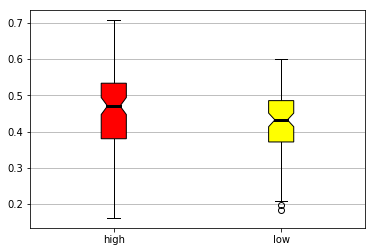

In [91]:
fig = plt.subplot(1,1,1)
bplot = fig.boxplot(result_compare_lst,
                meanline='black',
                notch=True,
                vert=True, 
                patch_artist=True)
#颜色填充
colors = ['red', 'yellow']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

for median in bplot['medians']:
    median.set(color='black', linewidth=3)
    
fig.yaxis.grid(True) #在y轴上添加网格线
fig.set_xticks([y+1 for y in range(len(result_compare_lst))] ) 
#fig.set_xlabel('细胞团') #设置x轴名称
#fig.set_ylabel('ylabel') #设置y轴名称

# 添加刻度
# 添加刻度名称，我们需要使用 plt.setp() 函数：

# 加刻度名称
plt.setp(fig, xticks=[1,2],
         xticklabels=['high','low'])
# 我们的刻度数是哪些，以及我们想要它添加的刻度标签是什么。
plt.savefig('f1.jpg')        
plt.show()